# Image processing & analysis 

:::{admonition} Chapter outline 
:class: tip

* **Image processing** involves changing images, usually in ways that will help interpretation later
* **Image analysis** involves converting images into measurements
* When image analysis is our goal, we almost always need image processing to get there
:::

In [1]:
%load_ext autoreload
%autoreload 2

# Default imports
import sys
sys.path.append('../../../')
from helpers import *
from matplotlib import pyplot as plt
from myst_nb import glue
import numpy as np
from scipy import ndimage

## Introduction

Successfully extracting useful information from microscopy images usually requires triumphing in two main battles.

The first is to overcome limitations in image quality and make the really interesting image content more clearly visible.
This involves **image processing**, the output of which is another image.
The second is to compute meaningful measurements, which could be presented in tables and summary plots.
This is **image analysis**.

Our main goal here is analysis -- but processing is almost always indispensable to get us there. 


## An image analysis workflow

So how do we figure out how to analyze our images?

Ultimately, we need some kind of workflow comprising multiple steps that eventually take us from image to results.
Each individual step might be small and straightforward, but the combination is powerful.

I tend to view the challenge of constructing any scientific image analysis workflow as akin to solving a puzzle.
In the end, we hope to extract some kind of quantitative measurements that are justified by the nature of the experiment and the facts of image formation.
One of the interesting features of the puzzle is that there is no single, fixed solution.

Although this might initially seem inconvenient, it can be liberating: it suggests there is room for lateral thinking and sparks of creativity.
The same images could be analyzed in quite different ways.
Sometimes giving quite different results, or answering quite different scientific questions.

Admittedly, if no solution comes to mind after pondering for a while then such an optimistic outlook quickly subsides, and the 'puzzle' may very well turn into an unbearably infuriating 'problem' -- but the point here is that _in principle_ image analysis _can_ be enjoyable.
What it takes is: 
* a modicum of enthusiasm (please bring your own)
* properly-acquired data, including all the necessary metadata (the subject of Part I)
* actually *having the tools at your disposal* to solve the puzzle (the subject Part II)

If you're a reluctant puzzler then it also helps to have the good luck not to be working on something horrendously difficult, but that is difficult to control.

### Combining processing tools

Image processing provides a whole host of tools that can be applied to puzzle-solving.
When piecing together processing steps to form a workflow, we usually have two main stages:

1. **Preprocessing**: the stuff you do to clean up the image, e.g. subtract the background, use a filter to reduce noise 
2. **Segmentation** the stuff you do to identify the things in the image you care about, e.g. apply a threshold to locate interesting features

Having successfully navigated these stages, there are usually some additional tasks remaining (e.g. making measurements of shape, intensity or dynamics).
However, these depend upon the specifics of the application and are *usually* not the hard part.
If you can identify what you want to quantify, you're a long way towards solving the puzzle.

{numref}`fig-workflow` shows an example of how these ideas can fit together.

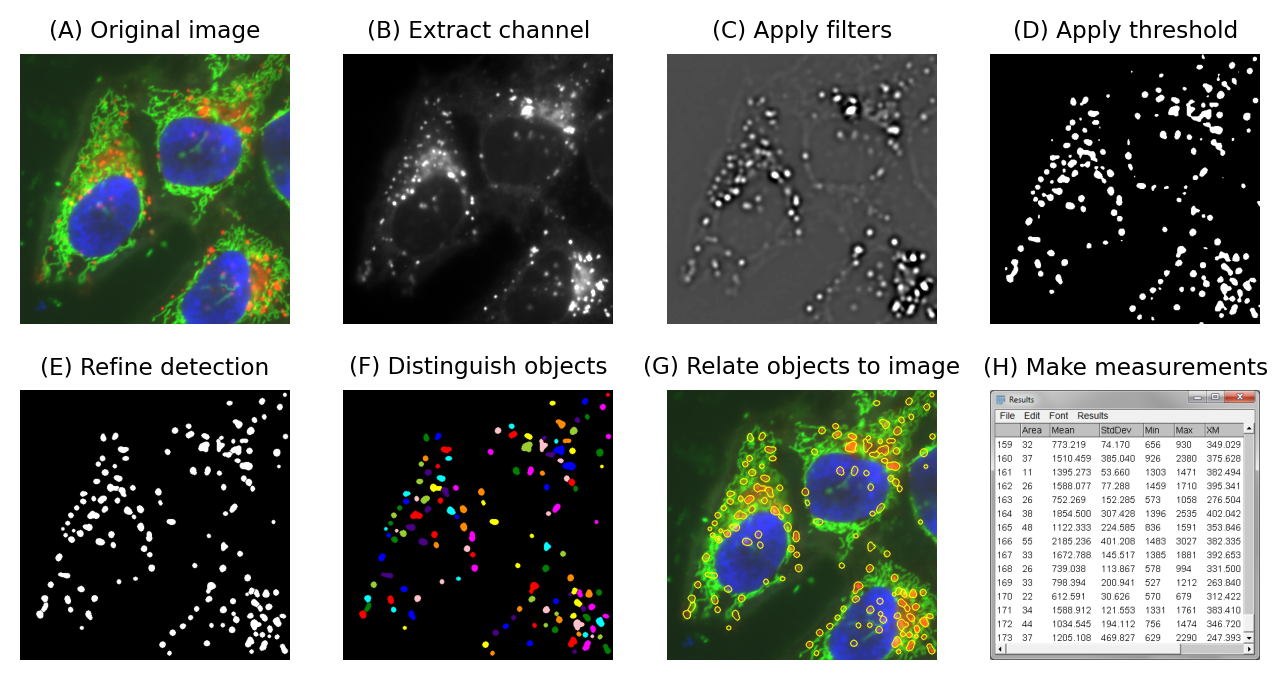

In [2]:
"""
Quick image analysis workflow to demonstrate the main steps involved.
"""

import numpy as np
from scipy import ndimage
from skimage.filters import threshold_triangle
from skimage.morphology import disk, extrema
from skimage.segmentation import watershed, mark_boundaries
from skimage.color import label2rgb
from matplotlib import pyplot as plt

# Read & crop image
x = 10
y = 0
s = 450
im_rgb = load_image('hela-cells.zip')[x:x+s, y:y+s, :].astype(np.float32)

# Convert to RGB - need to rescale each channel between 0 and 1
im_rgb_rgb = im_rgb - np.min(im_rgb.reshape((-1, 3)), axis=0).reshape((1, 1, 3))
im_rgb = im_rgb / np.percentile(im_rgb.reshape((-1, 3)), 99.5, axis=0).reshape((1, 1, 3))

# Extract channel of interest
im = im_rgb[:, :, 0]

# Apply difference of Gaussians filter
sigma = 3
sigma2 = sigma * 1.6
im_dog = ndimage.gaussian_filter(im, sigma) - ndimage.gaussian_filter(im, sigma2)

# Threshold for spot detection
bw_spots = im_dog > threshold_triangle(im_dog)

# Clean up with a morphological opening
strel = disk(3)
bw_spots_opened = ndimage.binary_opening(bw_spots, structure=strel)

# Perform distance-and-watershed-based split
bw_spots_dist = ndimage.distance_transform_edt(bw_spots_opened)
bw_spots_max = extrema.h_maxima(bw_spots_dist, 0.5)
bw_spots_max = ndimage.binary_dilation(bw_spots_max, structure=np.ones((3, 3)))
bw_spots_max = np.bitwise_and(bw_spots_opened, bw_spots_max)
lab_spots, n = ndimage.label(bw_spots_max)
lab_spots = watershed(-bw_spots_dist, markers=lab_spots, mask=bw_spots_opened, watershed_line=True)
bw_spots_cleaned = lab_spots > 0

# Show images
fig = create_figure(figsize=(8, 4))

show_image(np.clip(im_rgb, 0, 1), title='(A) Original image', pos=241)
show_image(im, title='(B) Extract channel', clip_percentile=0.5, pos=242)
show_image(im_dog, title='(C) Apply filters', clip_percentile=0.5, pos=243)
show_image(bw_spots, title='(D) Apply threshold', pos=244)
show_image(bw_spots_cleaned, title='(E) Refine detection', pos=245)
show_image(label2rgb(lab_spots, bg_label=0, bg_color='black'), title='(F) Distinguish objects', pos=246)
show_image(mark_boundaries(np.clip(im_rgb, 0, 1), lab_spots, mode='thick'), title='(G) Relate objects to image', pos=247)
show_image('images/workflow_results.png', title='(H) Make measurements', pos=248)
glue_fig('fig_overview_workflow', fig)

```{glue:figure} fig_overview_workflow
---
align: center
name: fig-workflow
---

A simple image analysis workflow for detecting and measuring spots in an image.
``` 

It won't be possible to cover *all* image processing tools in a book like this.
Rather, we will focus on the essential ones needed to get started: thresholds, filters, morphological operations and transforms.

These are already enough to solve many image analysis puzzles, and provide the framework to which more can be added later.